In [208]:
import pandas as pd
import glob
import configparser
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import anderson
from scipy.stats import f_oneway, kruskal
import json as js

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (40, 20)
plt.rcParams.update({
    "lines.color": "black",
    "patch.edgecolor": "black",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "black",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "grid.color": "gray",
    "figure.facecolor": "white",
    "figure.edgecolor": "white",
    "savefig.facecolor": "white",
    "savefig.edgecolor": "white",
    "font.size": 30,
    "xtick.labelsize":30,
    "ytick.labelsize":30,
    "lines.linewidth":1.,
    "legend.fontsize": 10,
    })

__ns3_path = os.popen('locate "ns-3.41" | grep /ns-3.41$').read().splitlines()[0]
sample_rate = 0.01
confidenceValue = 1.96 # 95% confidence interval

In [209]:
# convert strings like "2Mbps" to float
def read_data(__ns3_path, steadyStart, steadyEnd, rate, segment, checkColumn, projectColumn, experiment):
    file_paths = glob.glob('{}/scratch/Results/{}/{}/*_{}.csv'.format(__ns3_path, rate, experiment, segment))
    dfs = {}
    for file_path in file_paths:
        df_name = file_path.split('/')[-1].split('_')[0]
        df = pd.read_csv(file_path)
        df = df[df[checkColumn] == 1]
        df = df.reset_index(drop=True)
        df = df[df[projectColumn] > steadyStart * 1000000000]
        df = df[df[projectColumn] < steadyEnd * 1000000000]
        df = df.drop(columns=[checkColumn])
        dfs[df_name] = df
    return dfs

def read_data_flowIndicator(__ns3_path, rate):
    flows_name = []
    file_paths = glob.glob('{}/scratch/Results/{}/0/*_EndToEnd.csv'.format(__ns3_path, rate))
    for file_path in file_paths:
        flows_name.append(file_path.split('/')[-1].split('_')[0])
    return flows_name

def convert_to_float(x):
    if 'Mbps' in x:
        return float(x[:-4])
    elif 'Kbps' in x:
        return float(x[:-4]) / 1000
    elif 'Gbps' in x:
        return float(x[:-4]) * 1000
    elif 'ms' in x:
        return float(x[:-2])
    elif 'us' in x:
        return float(x[:-2]) / 1000
    else:
        return float(x)
    
def sample_data(data, sample_column):
    exit = False
    while not exit:
        # option 1: sample data with a fixed rate
        data_copy = data.sample(frac=sample_rate).sort_values(by=[sample_column])
        
        # option 2: sample data with a poisson process. Pick the closest packet to the arrival time
        # interArrivals = np.random.exponential(1/poisson_sample_rate, int(duration * poisson_sample_rate)) * 1000000000
        # interArrivals = np.cumsum(interArrivals)
        # interArrivals  = interArrivals + steadyStart * 1000000000
        # interArrivals = interArrivals[interArrivals > steadyStart * 1000000000]
        # interArrivals = interArrivals[interArrivals < steadyEnd * 1000000000]
        # data_copy = pd.DataFrame()
        # for i in range(len(interArrivals)):
        #     data_copy = pd.concat([data_copy, data.iloc[(data[sample_column] - interArrivals[i]).abs().argsort()[:1]]])

        # option 3: sample data with a poisson process. Pick the packets based on the exp distribution not the arrival time
        # exps = np.random.exponential(1/poisson_sample_rate, len(data))
        # c = np.abs(exps - 1/poisson_sample_rate) / (1/poisson_sample_rate) < 0.01
        # data_copy = data.copy()
        # data_copy['IsSample'] = c
        # data_copy = data_copy[data_copy['IsSample'] == True]
        # data_copy = data_copy.sort_values(by=[sample_column])


        data_copy['InterArrivalTime'] = data_copy[sample_column].diff()
        data_copy = data_copy.dropna().reset_index(drop=True)
        anderson_statistic, anderson_critical_values, _ = anderson(data_copy['InterArrivalTime'], 'expon')
        if anderson_statistic < anderson_critical_values[2]:
            # print('Anderson-Darling test passed')
            exit = True
    return data_copy.drop(columns=['InterArrivalTime'])

def get_switch_samples_delays(flowIndicatorDf, switchDf):
    l_df = flowIndicatorDf.copy()
    l_df = pd.merge(l_df, switchDf, on=['SourceIp', 'SourcePort', 'DestinationIp', 'DestinationPort', 'PayloadSize', 'SequenceNb'], how='right')
    l_df['ReceiveTime'] = l_df['ReceiveTime'].fillna(l_df['SampleTime'])
    l_df['SentTime'] = l_df['SentTime'].fillna(l_df['DepartTime'])
    return l_df

def switch_data(flowIndicatorDf, switchDf, sampling):
    l_df = flowIndicatorDf.copy()
    l_df = pd.merge(l_df, switchDf, on=['SourceIp', 'SourcePort', 'DestinationIp', 'DestinationPort', 'PayloadSize', 'SequenceNb'], how='inner')
    if sampling:
        l_df = sample_data(l_df, 'ReceiveTime')
    return l_df

def intermediateLink_data(flowIndicatorDf, source, dest):
    l_df = flowIndicatorDf.copy()
    l_df = pd.merge(l_df, source.drop(columns=['ReceiveTime']), on=['SourceIp', 'SourcePort', 'DestinationIp', 'DestinationPort', 'PayloadSize', 'SequenceNb'], how='inner')
    l_df = pd.merge(l_df, dest.drop(columns=['SentTime']), on=['SourceIp', 'SourcePort', 'DestinationIp', 'DestinationPort', 'PayloadSize', 'SequenceNb'], how='inner')
    # l_df = sample_data(l_df, 'SentTime')
    return l_df

def get_delayMean(data):
    data['Delay'] = abs(data['ReceiveTime'] - data['SentTime'])
    return data['Delay'].mean()

def get_delayStd(data):
    data['Delay'] = abs(data['ReceiveTime'] - data['SentTime'])
    return data['Delay'].std()

def get_delaySkew(data):
    data['Delay'] = abs(data['ReceiveTime'] - data['SentTime'])
    return data['Delay'].skew()

def get_statistics(data):
    statistics = {}
    statistics['DelayMean'] = get_delayMean(data.copy())
    statistics['DelayStd'] = get_delayStd(data.copy())
    statistics['sampleSize'] = len(data.copy())
    statistics['DelaySkew'] = get_delaySkew(data.copy())
    return statistics

In [210]:
def ECNMC(endToEnd_delayMean, sumOfSegments_DelayMeans, endToEnd_delayStd, MinSampleSize, confidenceValue):
    if abs(endToEnd_delayMean - sumOfSegments_DelayMeans) <= confidenceValue * (endToEnd_delayStd / np.sqrt(MinSampleSize)):
        return True
    else:  
        return False

def ECNMC_V2(endToEnd_delayMean, sumOfSegments_DelayMeans, maxEpsilon):
    if abs(endToEnd_delayMean - sumOfSegments_DelayMeans) / endToEnd_delayMean <= maxEpsilon:
        return True
    else:  
        return False
    
def check_single_delayConsistency(endToEnd_statistics, switches_statistics, interLinks_statistics, confidenceValue):
    switches_delayMeans = [value['DelayMean'] for value in switches_statistics.values()]
    interLinks_delaymeans = [value['DelayMean'] for value in interLinks_statistics.values()]
    switches_sampleSizes = [value['sampleSize'] for value in switches_statistics.values()]
    MinSampleSize = min(switches_sampleSizes)
    sumOfSegmentsDelayMeans = sum(switches_delayMeans + interLinks_delaymeans)

    return ECNMC(endToEnd_statistics['DelayMean'], sumOfSegmentsDelayMeans, endToEnd_statistics['DelayStd'], MinSampleSize, confidenceValue)
        
def check_single_delayConsistency_V2(endToEnd_statistics, switches_statistics, interLinks_statistics, confidenceValue):
    # calculate the epsilon = confidenceValue * (switches_delayStd / (sqrt(switches_sampleSize) * switches_delayMean)) for each switch
    switches_delayMeans = [value['DelayMean'] for value in switches_statistics.values()]
    switches_delayStds = [value['DelayStd'] for value in switches_statistics.values()]
    switches_sampleSizes = [value['sampleSize'] for value in switches_statistics.values()]
    interLinks_delaymeans = [value['DelayMean'] for value in interLinks_statistics.values()]
    interLinks_delayStds = [value['DelayStd'] for value in interLinks_statistics.values()]
    interLinks_sampleSizes = [value['sampleSize'] for value in interLinks_statistics.values()]

    segments_delayMeans = switches_delayMeans + interLinks_delaymeans
    segments_delayStds = switches_delayStds + interLinks_delayStds
    segments_sampleSizes = switches_sampleSizes + interLinks_sampleSizes

    epsilons = [confidenceValue * (segments_delayStds[i] / (np.sqrt(segments_sampleSizes[i]) * segments_delayMeans[i])) for i in range(len(segments_delayMeans))]
    maxEpsilon = max(epsilons)
    sumOfSegmentsDelayMeans = sum(segments_delayMeans)

    return ECNMC_V2(endToEnd_statistics['DelayMean'], sumOfSegmentsDelayMeans, maxEpsilon)




def check_all_delayConsistency(endToEnd_statistics, switches_statistics, interLinks_statistics, confidenceValue):
    res = {}
    res['DominantAssumption'] = {}
    res['General'] = {}
    for flow in endToEnd_statistics.keys():
        res['DominantAssumption'][flow] = check_single_delayConsistency(endToEnd_statistics[flow], switches_statistics[flow], interLinks_statistics[flow], confidenceValue)
        res['General'][flow] = check_single_delayConsistency_V2(endToEnd_statistics[flow], switches_statistics[flow], interLinks_statistics[flow], confidenceValue)
    return res

In [211]:
class AppKey:
    def __init__(self, sourceIp, sourcePort, destIp, destPort):
        self.sourceIp = sourceIp
        self.sourcePort = sourcePort
        self.destIp = destIp
        self.destPort = destPort

In [212]:
config = configparser.ConfigParser()
config.read('Parameters.config')
hostToTorLinkRate = convert_to_float(config.get('Settings', 'hostToTorLinkRate'))
torToAggLinkRate = config.get('Settings', 'torToAggLinkRate')
aggToCoreLinkRate = convert_to_float(config.get('Settings', 'aggToCoreLinkRate'))
hostToTorLinkDelay = convert_to_float(config.get('Settings', 'hostToTorLinkDelay'))
torToAggLinkDelay = convert_to_float(config.get('Settings', 'torToAggLinkDelay'))
aggToCoreLinkDelay = convert_to_float(config.get('Settings', 'aggToCoreLinkDelay'))
pctPacedBack = convert_to_float(config.get('Settings', 'pctPacedBack'))
appDataRate = convert_to_float(config.get('Settings', 'appDataRate'))
duration = convert_to_float(config.get('Settings', 'duration'))
steadyStart = convert_to_float(config.get('Settings', 'steadyStart'))
steadyEnd = convert_to_float(config.get('Settings', 'steadyEnd'))
sampleRate = convert_to_float(config.get('Settings', 'sampleRate'))
experiments = int(config.get('Settings', 'experiments'))
serviceRateScales = [float(x) for x in config.get('Settings', 'serviceRateScales').split(',')]

print("hostToTorLinkRate: ", hostToTorLinkRate, " Mbps")
print("torToAggLinkRate: ", torToAggLinkRate)
print("aggToCoreLinkRate: ", aggToCoreLinkRate, " Mbps")
print("hostToTorLinkDelay: ", hostToTorLinkDelay, " ms")
print("torToAggLinkDelay: ", torToAggLinkDelay, " ms")
print("aggToCoreLinkDelay: ", aggToCoreLinkDelay, " ms")
print("pctPacedBack: ", pctPacedBack, " %")
print("appDataRate: ", appDataRate, " Mbps")
print("duration: ", duration, " s")
print("steadyStart: ", steadyStart, " s")
print("steadyEnd: ", steadyEnd, " s")
print("sampleRate", sampleRate)
print("experiments: ", experiments)
print("serviceRateScales: ", serviceRateScales)
rate = serviceRateScales[-1]

hostToTorLinkRate:  10.0  Mbps
torToAggLinkRate:  10Mbps
aggToCoreLinkRate:  10.0  Mbps
hostToTorLinkDelay:  3.0  ms
torToAggLinkDelay:  3.0  ms
aggToCoreLinkDelay:  3.0  ms
pctPacedBack:  0.8  %
appDataRate:  10.0  Mbps
duration:  10.0  s
steadyStart:  2.0  s
steadyEnd:  9.0  s
sampleRate 1000.0
experiments:  1
serviceRateScales:  [0.8, 0.9, 1.0, 1.1, 1.25]


# Reading the Groundtruth

In [213]:
endToEnd_dfs = read_data(__ns3_path, steadyStart, steadyEnd, rate, 'EndToEnd', 'IsReceived', 'SentTime', '0')
print(*[len(endToEnd_dfs[i]) for i in endToEnd_dfs.keys()])

7878 8752


In [214]:
# from endToEnd data, calculate the average data rate
endToEnd_dataRates = {}
for flow in endToEnd_dfs.keys():
    endToEnd_dataRates[flow] = endToEnd_dfs[flow]['PayloadSize'].sum() * 8 / (10) / 1000000
print(endToEnd_dataRates)

{'R0h1R1h1': 6.3828344, 'R0h0R1h0': 6.4902264}


In [215]:
switches_dfs = read_data(__ns3_path, steadyStart, steadyEnd, rate, 'Switch', 'IsSent', 'ReceiveTime', '0')
print(*[len(switches_dfs[i]) for i in switches_dfs.keys()])

16994 16991


# Reading the Samples

In [216]:
samples_dfs = read_data(__ns3_path, steadyStart, steadyEnd, rate, 'PoissonSampler', 'IsDeparted', 'SampleTime', '0')
print(*[len(samples_dfs[i]) for i in samples_dfs.keys()])

6979 6937 7027


# Intermediate links groundtruth statistics

In [217]:
interLinks_statistics = {}
for flow in endToEnd_dfs.keys():
    interLinks_statistics[flow] = {}
    interLinks_statistics[flow][('source', 'T0')] = get_statistics(intermediateLink_data(endToEnd_dfs[flow].drop(columns=['SentTime', 'ReceiveTime']), endToEnd_dfs[flow], switches_dfs['T0']))
    interLinks_statistics[flow][('T0', 'T1')] = get_statistics(intermediateLink_data(endToEnd_dfs[flow].drop(columns=['SentTime', 'ReceiveTime']), switches_dfs['T0'], switches_dfs['T1']))
    interLinks_statistics[flow][('T1', 'dest')] = get_statistics(intermediateLink_data(endToEnd_dfs[flow].drop(columns=['SentTime', 'ReceiveTime']), switches_dfs['T1'], endToEnd_dfs[flow]))

interLinks_statistics

{'R0h1R1h1': {('source', 'T0'): {'DelayMean': 420536686.2893617,
   'DelayStd': 462242844.4906737,
   'sampleSize': 7520,
   'DelaySkew': 2.0657053155904332},
  ('T0', 'T1'): {'DelayMean': 5872422.4135408355,
   'DelayStd': 57140725.67491264,
   'sampleSize': 7518,
   'DelaySkew': 22.876109012556565},
  ('T1', 'dest'): {'DelayMean': 6636902.261239692,
   'DelayStd': 57105666.68883745,
   'sampleSize': 7518,
   'DelaySkew': 22.878442756963434}},
 'R0h0R1h0': {('source', 'T0'): {'DelayMean': 529038266.2156652,
   'DelayStd': 631484286.1533439,
   'sampleSize': 8388,
   'DelaySkew': 1.8612881296795585},
  ('T0', 'T1'): {'DelayMean': 17309331.37805314,
   'DelayStd': 150409544.2720306,
   'sampleSize': 8393,
   'DelaySkew': 12.98996369399318},
  ('T1', 'dest'): {'DelayMean': 16979605.70816935,
   'DelayStd': 136347342.0176118,
   'sampleSize': 8385,
   'DelaySkew': 12.942759717275342}}}

# Switches statistics

In [218]:
samples_statistics = {}
samples_statistics['Overall'] = {}
samples_statistics['PerTrafficStream'] = {}

for flow in endToEnd_dfs.keys():
    samples_statistics['Overall'][flow] = {}
    samples_statistics['Overall'][flow]['T0'] = get_statistics(get_switch_samples_delays(switches_dfs['T0'], samples_dfs['T0T1']))
    samples_statistics['Overall'][flow]['T1'] = get_statistics(get_switch_samples_delays(switches_dfs['T1'], samples_dfs['T1.R' + flow.split('R')[-1]]))

    samples_statistics['PerTrafficStream'][flow] = {}
    samples_statistics['PerTrafficStream'][flow]['T0'] = get_statistics(switch_data(endToEnd_dfs[flow].drop(columns=['SentTime', 'ReceiveTime']), switches_dfs['T0'], True))
    samples_statistics['PerTrafficStream'][flow]['T1'] = get_statistics(switch_data(endToEnd_dfs[flow].drop(columns=['SentTime', 'ReceiveTime']), switches_dfs['T1'], True))

samples_statistics

{'Overall': {'R0h1R1h1': {'T0': {'DelayMean': 34704.55624014902,
    'DelayStd': 51206.14524418163,
    'sampleSize': 6979,
    'DelaySkew': 1.6383659615442112},
   'T1': {'DelayMean': 344357.19806625904,
    'DelayStd': 533143.4076964884,
    'sampleSize': 7033,
    'DelaySkew': 1.1530874699910698}},
  'R0h0R1h0': {'T0': {'DelayMean': 34704.55624014902,
    'DelayStd': 51206.14524418163,
    'sampleSize': 6979,
    'DelaySkew': 1.6383659615442112},
   'T1': {'DelayMean': 429314.9933964973,
    'DelayStd': 568917.3327631389,
    'sampleSize': 6966,
    'DelaySkew': 0.7971343429066802}}},
 'PerTrafficStream': {'R0h1R1h1': {'T0': {'DelayMean': 78742.78378378379,
    'DelayStd': 62020.872572365035,
    'sampleSize': 74,
    'DelaySkew': 0.45401473437177126},
   'T1': {'DelayMean': 458950.4324324324,
    'DelayStd': 452918.36362617323,
    'sampleSize': 74,
    'DelaySkew': 1.1807355862503062}},
  'R0h0R1h0': {'T0': {'DelayMean': 81902.41463414633,
    'DelayStd': 72484.92410012764,
    's

In [219]:
groundtruth_statistics = {}
groundtruth_statistics['Overall'] = {}
groundtruth_statistics['PerTrafficStream'] = {}

for flow in endToEnd_dfs.keys():
    groundtruth_statistics['Overall'][flow] = {}
    groundtruth_statistics['Overall'][flow]['T0'] = get_statistics(switches_dfs['T0'])
    groundtruth_statistics['Overall'][flow]['T1'] = get_statistics(switches_dfs['T1'])

    groundtruth_statistics['PerTrafficStream'][flow] = {}
    groundtruth_statistics['PerTrafficStream'][flow]['T0'] = get_statistics(switch_data(endToEnd_dfs[flow].drop(columns=['SentTime', 'ReceiveTime']), switches_dfs['T0'], False))
    groundtruth_statistics['PerTrafficStream'][flow]['T1'] = get_statistics(switch_data(endToEnd_dfs[flow].drop(columns=['SentTime', 'ReceiveTime']), switches_dfs['T1'], False))

groundtruth_statistics

{'Overall': {'R0h1R1h1': {'T0': {'DelayMean': 77682.35348125479,
    'DelayStd': 62216.66887438335,
    'sampleSize': 16991,
    'DelaySkew': 0.7089173471467861},
   'T1': {'DelayMean': 566830.5476638813,
    'DelayStd': 503285.4443585117,
    'sampleSize': 16994,
    'DelaySkew': 0.6949485580595847}},
  'R0h0R1h0': {'T0': {'DelayMean': 77682.35348125479,
    'DelayStd': 62216.66887438335,
    'sampleSize': 16991,
    'DelaySkew': 0.7089173471467861},
   'T1': {'DelayMean': 566830.5476638813,
    'DelayStd': 503285.4443585117,
    'sampleSize': 16994,
    'DelaySkew': 0.6949485580595847}}},
 'PerTrafficStream': {'R0h1R1h1': {'T0': {'DelayMean': 77678.97891083822,
    'DelayStd': 63068.14742269047,
    'sampleSize': 7492,
    'DelaySkew': 0.7424672657037816},
   'T1': {'DelayMean': 547707.5228304405,
    'DelayStd': 502560.92894845316,
    'sampleSize': 7490,
    'DelaySkew': 0.7781487816959045}},
  'R0h0R1h0': {'T0': {'DelayMean': 79551.18644476603,
    'DelayStd': 62455.72285484849,
 

ANOVA test: F-value: 3.503965670758451, p-value: 0.06124054451927044
Kruskal test: H-value: 5.204791008938163, p-value: 0.02252472262723001



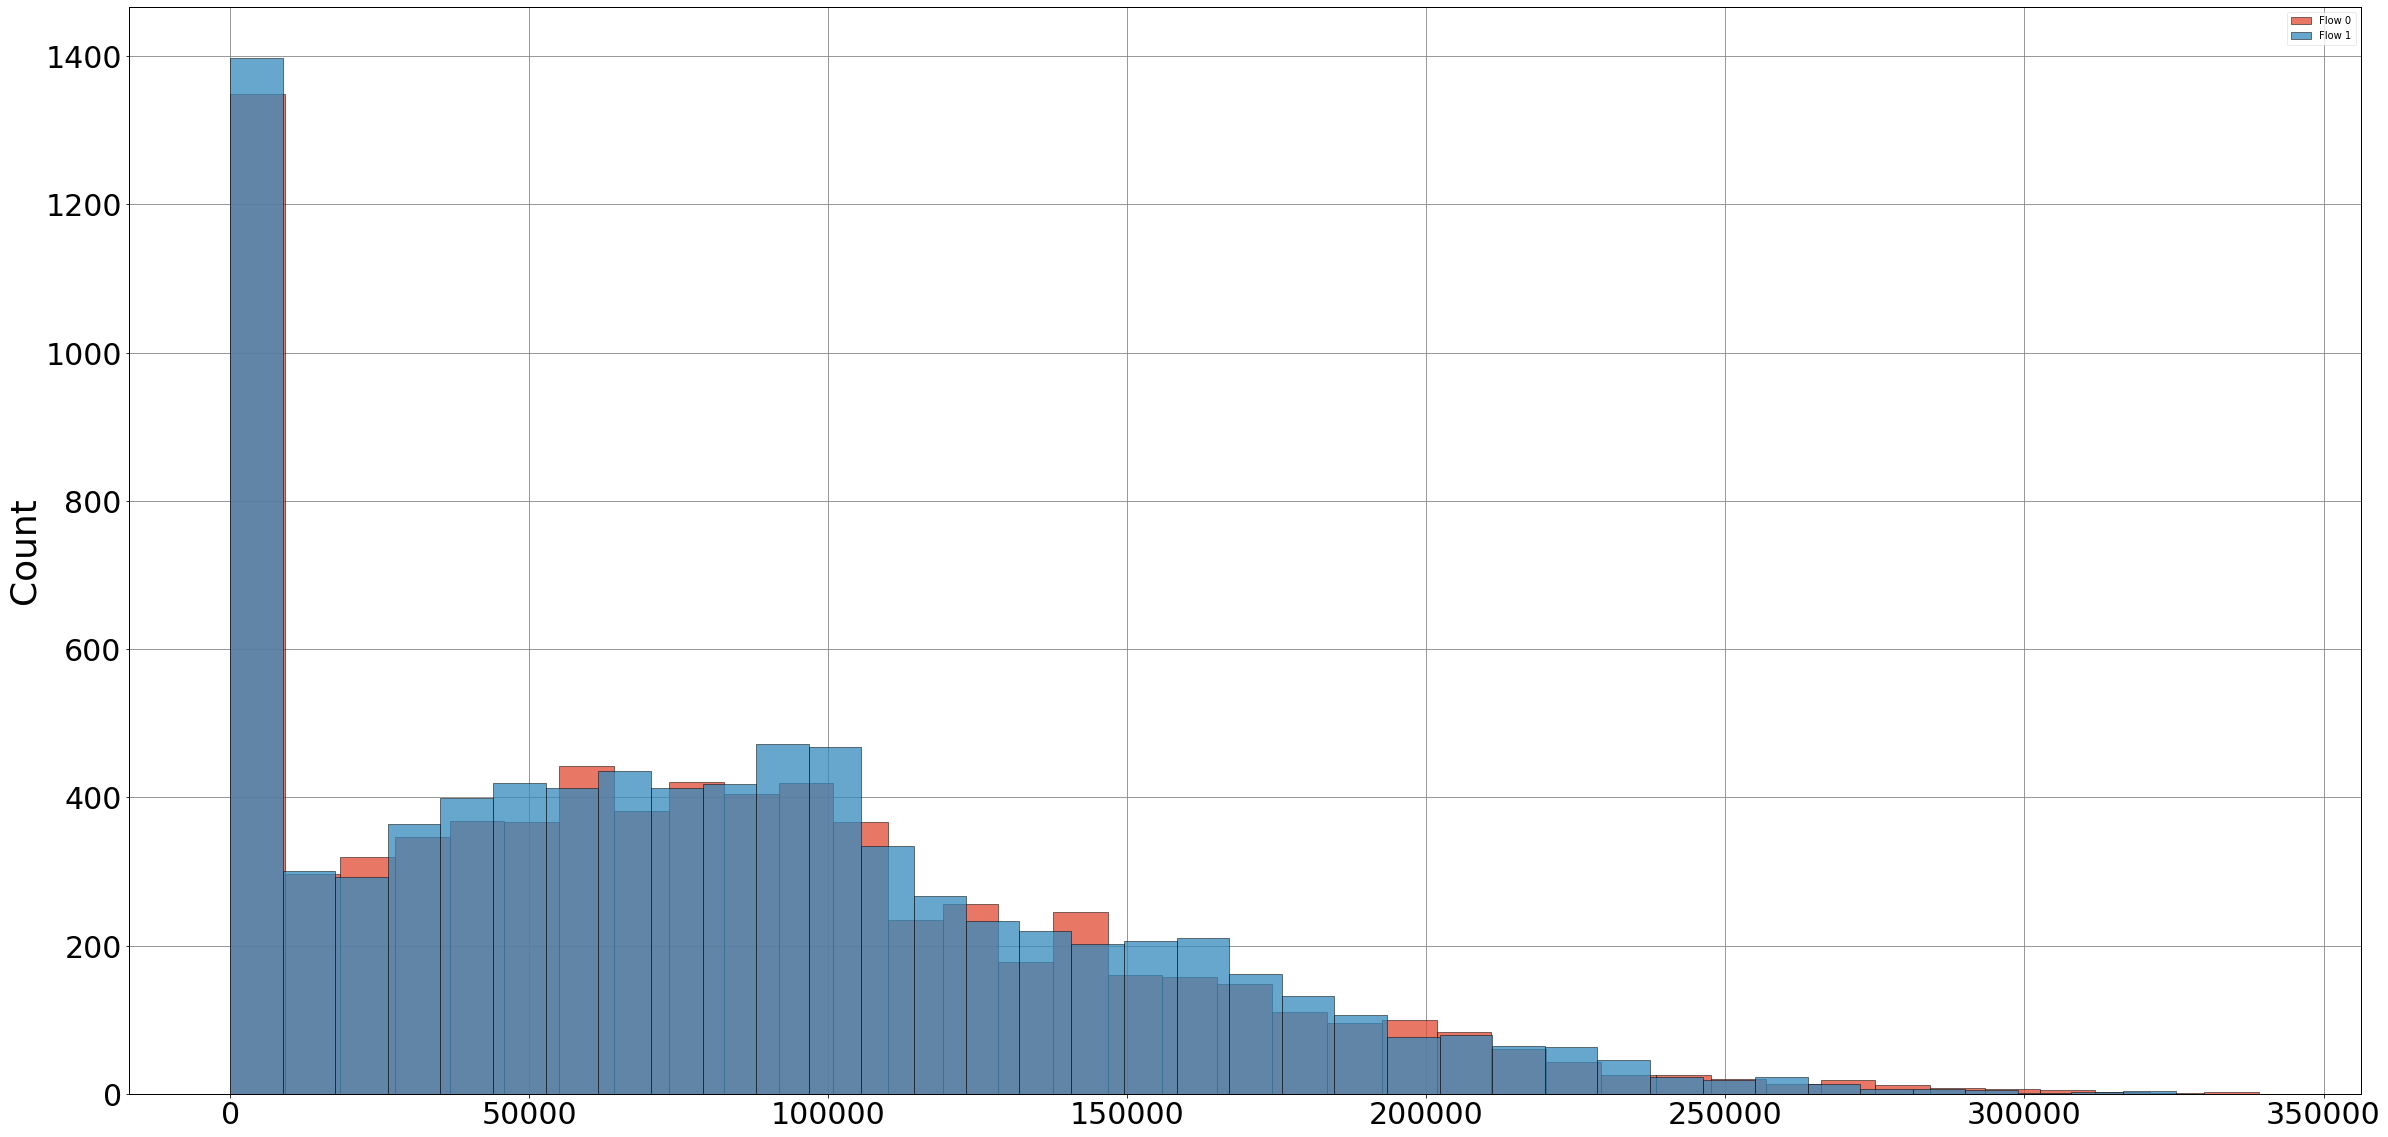

In [220]:
# ANOVA test
flows = []
for flow in endToEnd_dfs.keys():
    flow_on_switch = switch_data(endToEnd_dfs[flow].drop(columns=['SentTime', 'ReceiveTime']), switches_dfs['T0'], False)
    flow_on_switch['Delay'] = abs(flow_on_switch['ReceiveTime'] - flow_on_switch['SentTime'])
    flows.append(flow_on_switch)

anova_res  = f_oneway(*[flows[i]['Delay'] for i in range(len(flows))])
kruskal_res = kruskal(*[flows[i]['Delay'] for i in range(len(flows))])
prt = "ANOVA test: F-value: {}, p-value: {}\n".format(anova_res.statistic, anova_res.pvalue)
prt += "Kruskal test: H-value: {}, p-value: {}\n".format(kruskal_res.statistic, kruskal_res.pvalue)
print(prt)

# plot the delay distribution of the flows
fig, ax = plt.subplots(1, 1)
for i in range(len(flows)):
    sns.histplot(np.array(flows[i]['Delay']), ax=ax, label='Flow {}'.format(i))
plt.legend()
plt.show()


# Groundtruth delay mean and std

In [221]:
# calculate the mean and std of thet delay of each flow
endToEnd_statistics = {}
for flow in endToEnd_dfs.keys():
    # endToEnd_statistics[flow] = get_statistics(sample_data(endToEnd_dfs[flow], 'SentTime'))
    endToEnd_statistics[flow] = get_statistics(endToEnd_dfs[flow])

print(endToEnd_statistics)

{'R0h1R1h1': {'DelayMean': 441095037.4785479, 'DelayStd': 467074709.3204033, 'sampleSize': 7878, 'DelaySkew': 1.9315302567315202}, 'R0h0R1h0': {'DelayMean': 555094077.397052, 'DelayStd': 646597100.8732718, 'sampleSize': 8752, 'DelaySkew': 2.107304881992991}}


# End to End and Persegment Compatibility Check

In [222]:
results = {}
results['Overall'] = {}
results['PerTrafficStream'] = {}
results['Overall']['groundtruth'] = check_all_delayConsistency(endToEnd_statistics, groundtruth_statistics['Overall'], interLinks_statistics, confidenceValue)
results['Overall']['samples'] = check_all_delayConsistency(endToEnd_statistics, samples_statistics['Overall'], interLinks_statistics, confidenceValue)
results['PerTrafficStream']['groundtruth'] = check_all_delayConsistency(endToEnd_statistics, groundtruth_statistics['PerTrafficStream'], interLinks_statistics, confidenceValue)
results['PerTrafficStream']['samples'] = check_all_delayConsistency(endToEnd_statistics, samples_statistics['PerTrafficStream'], interLinks_statistics, confidenceValue)

results

{'Overall': {'groundtruth': {'DominantAssumption': {'R0h1R1h1': False,
    'R0h0R1h0': True},
   'General': {'R0h1R1h1': True, 'R0h0R1h0': True}},
  'samples': {'DominantAssumption': {'R0h1R1h1': True, 'R0h0R1h0': True},
   'General': {'R0h1R1h1': True, 'R0h0R1h0': True}}},
 'PerTrafficStream': {'groundtruth': {'DominantAssumption': {'R0h1R1h1': True,
    'R0h0R1h0': True},
   'General': {'R0h1R1h1': True, 'R0h0R1h0': True}},
  'samples': {'DominantAssumption': {'R0h1R1h1': True, 'R0h0R1h0': True},
   'General': {'R0h1R1h1': True, 'R0h0R1h0': True}}}}

# Repeat sampling to check if the relation holds more than 95% of the time

In [223]:
# def prepare_results(flows):
#     rounds_results = {}
#     rounds_results['Overall'] = {}
#     rounds_results['PerTrafficStream'] = {}
#     # rounds_results['Overall']['groundtruth'] = {}
#     rounds_results['Overall']['samples'] = {}
#     # rounds_results['PerTrafficStream']['groundtruth'] = {}
#     rounds_results['PerTrafficStream']['samples'] = {}
#     # rounds_results['Overall']['groundtruth']['DominantAssumption'] = {}
#     # rounds_results['Overall']['groundtruth']['General'] = {}
#     rounds_results['Overall']['samples']['DominantAssumption'] = {}
#     rounds_results['Overall']['samples']['General'] = {}
#     # rounds_results['PerTrafficStream']['groundtruth']['DominantAssumption'] = {}
#     # rounds_results['PerTrafficStream']['groundtruth']['General'] = {}
#     rounds_results['PerTrafficStream']['samples']['DominantAssumption'] = {}
#     rounds_results['PerTrafficStream']['samples']['General'] = {}
#     rounds_results['ANOVA'] = 0
#     rounds_results['Kruskal'] = 0
#     rounds_results['EndToEndMean'] = {}
#     rounds_results['EndToEndStd'] = {}
#     rounds_results['EndToEndSkew'] = {}
#     for flow in flows:
#         # rounds_results['Overall']['groundtruth']['DominantAssumption'][flow] = 0
#         # rounds_results['Overall']['groundtruth']['General'][flow] = 0
#         rounds_results['Overall']['samples']['DominantAssumption'][flow] = 0
#         rounds_results['Overall']['samples']['General'][flow] = 0
#         # rounds_results['PerTrafficStream']['groundtruth']['DominantAssumption'][flow] = 0
#         # rounds_results['PerTrafficStream']['groundtruth']['General'][flow] = 0
#         rounds_results['PerTrafficStream']['samples']['DominantAssumption'][flow] = 0
#         rounds_results['PerTrafficStream']['samples']['General'][flow] = 0
#         rounds_results['EndToEndMean'][flow] = 0
#         rounds_results['EndToEndStd'][flow] = 0
#         rounds_results['EndToEndSkew'][flow] = 0

#     rounds_results['experiments'] = 0
#     return rounds_results

# def delayProcess_consistency_check(flows, rounds_results):
#     # Observing the same delay process test on the common swtiches(T0)
#     for flow_on_switch in flows:
#         flow_on_switch['Delay'] = abs(flow_on_switch['ReceiveTime'] - flow_on_switch['SentTime'])

#     anova_res  = f_oneway(*[flows[i]['Delay'] for i in range(len(flows))])
#     kruskal_res = kruskal(*[flows[i]['Delay'] for i in range(len(flows))])
#     if anova_res.pvalue > 0.05:
#         rounds_results['ANOVA'] += 1
#     if kruskal_res.pvalue > 0.05:
#         rounds_results['Kruskal'] += 1

# def plot_delay_distribution(rate, switches_dfs, common_switch_sample_df):
#     # plot the delay distribution of SWitch T0 and Sample T0
#     fig, ax = plt.subplots(1, 2)
#     sns.histplot(common_switch_sample_df['SentTime'] - common_switch_sample_df['ReceiveTime'], ax=ax[0])
#     sns.histplot(switches_dfs['T0']['SentTime'] - switches_dfs['T0']['ReceiveTime'], ax=ax[1])
#     ax[0].set_title('Sample T0')
#     ax[1].set_title('Switch T0')
#     plt.savefig('results/{}/{}_T0_overall_delayDist.png'.format(rate, rate))

# def compatibility_check(confidenceValue, rounds_results, samples_statistics, interLinks_statistics, endToEnd_statistics, flows_name):
#     # End to End and Persegment Compatibility Check
#     results = {}
#     results['Overall'] = {}
#     results['PerTrafficStream'] = {}
#     # results['Overall']['groundtruth'] = check_all_delayConsistency(endToEnd_statistics, groundtruth_statistics['Overall'], interLinks_statistics, confidenceValue)
#     results['Overall']['samples'] = check_all_delayConsistency(endToEnd_statistics, samples_statistics['Overall'], interLinks_statistics, confidenceValue)
#     # results['PerTrafficStream']['groundtruth'] = check_all_delayConsistency(endToEnd_statistics, groundtruth_statistics['PerTrafficStream'], interLinks_statistics, confidenceValue)
#     results['PerTrafficStream']['samples'] = check_all_delayConsistency(endToEnd_statistics, samples_statistics['PerTrafficStream'], interLinks_statistics, confidenceValue)

#     for flow in flows_name:
#         # if results['Overall']['groundtruth']['DominantAssumption'][flow]:
#         #     rounds_results['Overall']['groundtruth']['DominantAssumption'][flow] += 1
#         # if results['Overall']['groundtruth']['General'][flow]:
#         #     rounds_results['Overall']['groundtruth']['General'][flow] += 1
#         if results['Overall']['samples']['DominantAssumption'][flow]:
#             rounds_results['Overall']['samples']['DominantAssumption'][flow] += 1
#         if results['Overall']['samples']['General'][flow]:
#             rounds_results['Overall']['samples']['General'][flow] += 1
#         # if results['PerTrafficStream']['groundtruth']['DominantAssumption'][flow]:
#         #     rounds_results['PerTrafficStream']['groundtruth']['DominantAssumption'][flow] += 1
#         # if results['PerTrafficStream']['groundtruth']['General'][flow]:
#         #     rounds_results['PerTrafficStream']['groundtruth']['General'][flow] += 1
#         if results['PerTrafficStream']['samples']['DominantAssumption'][flow]:
#             rounds_results['PerTrafficStream']['samples']['DominantAssumption'][flow] += 1
#         if results['PerTrafficStream']['samples']['General'][flow]:
#             rounds_results['PerTrafficStream']['samples']['General'][flow] += 1


# def analyze_single_experiment(rate, steadyStart, steadyEnd, confidenceValue, rounds_results, experiment=0, ns3_path=__ns3_path):
#     endToEnd_dfs = read_data(__ns3_path, steadyStart, steadyEnd, rate, 'EndToEnd', 'IsReceived', 'SentTime', str(experiment))
#     switches_dfs = read_data(__ns3_path, steadyStart, steadyEnd, rate, 'Switch', 'IsSent', 'ReceiveTime', str(experiment))
#     samples_dfs = read_data(__ns3_path, steadyStart, steadyEnd, rate, 'PoissonSampler', 'IsDeparted', 'SampleTime', str(experiment))

#     # Intermediate links groundtruth statistics
#     interLinks_statistics = {}
#     for flow in endToEnd_dfs.keys():
#         interLinks_statistics[flow] = {}
#         interLinks_statistics[flow][('source', 'T0')] = get_statistics(intermediateLink_data(endToEnd_dfs[flow].drop(columns=['SentTime', 'ReceiveTime']), endToEnd_dfs[flow], switches_dfs['T0']))
#         interLinks_statistics[flow][('T0', 'T1')] = get_statistics(intermediateLink_data(endToEnd_dfs[flow].drop(columns=['SentTime', 'ReceiveTime']), switches_dfs['T0'], switches_dfs['T1']))
#         interLinks_statistics[flow][('T1', 'dest')] = get_statistics(intermediateLink_data(endToEnd_dfs[flow].drop(columns=['SentTime', 'ReceiveTime']), switches_dfs['T1'], endToEnd_dfs[flow]))


#     # samples switches statistics
#     samples_statistics = {}
#     samples_statistics['Overall'] = {}
#     samples_statistics['PerTrafficStream'] = {}
#     common_switch_sample_df = get_switch_samples_delays(switches_dfs['T0'], samples_dfs['T0T1'])
#     for flow in endToEnd_dfs.keys():
#         samples_statistics['Overall'][flow] = {}
#         samples_statistics['Overall'][flow]['T0'] = get_statistics(common_switch_sample_df)
#         samples_statistics['Overall'][flow]['T1'] = get_statistics(get_switch_samples_delays(switches_dfs['T1'], samples_dfs['T1.R' + flow.split('R')[-1]]))

#         samples_statistics['PerTrafficStream'][flow] = {}
#         samples_statistics['PerTrafficStream'][flow]['T0'] = get_statistics(switch_data(endToEnd_dfs[flow].drop(columns=['SentTime', 'ReceiveTime']), switches_dfs['T0'], True))
#         samples_statistics['PerTrafficStream'][flow]['T1'] = get_statistics(switch_data(endToEnd_dfs[flow].drop(columns=['SentTime', 'ReceiveTime']), switches_dfs['T1'], True))

#     # groundtruth switches statistics
#     groundtruth_statistics = {}
#     groundtruth_statistics['Overall'] = {}
#     groundtruth_statistics['PerTrafficStream'] = {}

#     flows = []
#     for flow in endToEnd_dfs.keys():
#         # groundtruth_statistics['Overall'][flow] = {}
#         # groundtruth_statistics['Overall'][flow]['T0'] = get_statistics(switches_dfs['T0'])
#         # groundtruth_statistics['Overall'][flow]['T1'] = get_statistics(switches_dfs['T1'])

#         # groundtruth_statistics['PerTrafficStream'][flow] = {}
#         flow_on_switch = switch_data(endToEnd_dfs[flow].drop(columns=['SentTime', 'ReceiveTime']), switches_dfs['T0'], False)
#         flows.append(flow_on_switch)
#         # groundtruth_statistics['PerTrafficStream'][flow]['T0'] = get_statistics(flow_on_switch)
#         # groundtruth_statistics['PerTrafficStream'][flow]['T1'] = get_statistics(switch_data(endToEnd_dfs[flow].drop(columns=['SentTime', 'ReceiveTime']), switches_dfs['T1'], False))

#     # endToEnd_statistics
#     endToEnd_statistics = {}
#     for flow in endToEnd_dfs.keys():
#         endToEnd_statistics[flow] = get_statistics(endToEnd_dfs[flow])
#         rounds_results['EndToEndMean'][flow] += endToEnd_statistics[flow]['DelayMean']
#         rounds_results['EndToEndStd'][flow] += endToEnd_statistics[flow]['DelayStd']
#         rounds_results['EndToEndSkew'][flow] += endToEnd_statistics[flow]['DelaySkew']

#     rounds_results['experiments'] += 1

#     delayProcess_consistency_check(flows, rounds_results)

#     plot_delay_distribution(rate, switches_dfs, common_switch_sample_df)

#     compatibility_check(confidenceValue, rounds_results, samples_statistics, interLinks_statistics, endToEnd_statistics, endToEnd_dfs.keys())

# def analyze_all_experiments(rate, steadyStart, steadyEnd, confidenceValue, experiments=3, ns3_path=__ns3_path):
#     flows_name = read_data_flowIndicator(ns3_path, rate)

#     rounds_results = prepare_results(flows_name)
#     for experiment in range(experiments):
#         analyze_single_experiment(rate, steadyStart, steadyEnd, confidenceValue, rounds_results, experiment, ns3_path)
    
#     rounds_results['EndToEndMean'] = {key: value / experiments for key, value in rounds_results['EndToEndMean'].items()}
#     rounds_results['EndToEndStd'] = {key: value / experiments for key, value in rounds_results['EndToEndStd'].items()}
#     rounds_results['EndToEndSkew'] = {key: value / experiments for key, value in rounds_results['EndToEndSkew'].items()}
    
#     with open('results/{}/{}_results.json'.format(rate,rate), 'w') as f:
#         js.dump(rounds_results, f)


In [224]:
# for rate in serviceRateScales:
#     analyze_all_experiments(rate, steadyStart, steadyEnd, confidenceValue, experiments, __ns3_path)